In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
from pathlib import Path

In [ ]:
(ds_train, ds_validation, ds_test), metadata  = tfds.load(
    "tf_flowers", 
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    as_supervised=True, 
    with_info=True
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
num_examples = metadata.splits["train"].num_examples
num_classes = metadata.features["label"].num_classes
labels = metadata.features["label"].names
print(num_examples)
print(num_classes)
print(labels)

3670
5
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


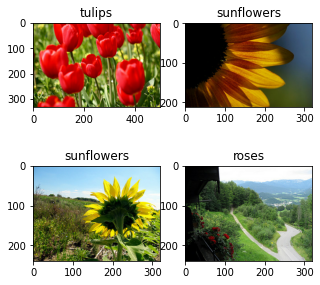

In [ ]:
samples = ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    img_array, img_label_idx = img
    ax = fig.add_subplot(2,2, i + 1)    
    ax.imshow(img_array)    
    ax.set_title(labels[img_label_idx])
plt.show()

In [ ]:
IMG_SIZE = 180

resize_and_rescale = Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1)
])


def prepare_for_training(ds_subset, batch_size = 32, shuffle=False, augment=False):
    ds_subset  =  ds_subset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if shuffle:
        ds_subset = ds_subset.shuffle(1000)
    
    # create data batches
    ds_subset = ds_subset.batch(batch_size)

    # apply data augmentation
    if augment:        
        ds_subset= ds_subset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


transformed_ds_train = prepare_for_training(ds_train, shuffle=True, augment=True)
transformed_ds_val = prepare_for_training(ds_validation)
transformed_ds_test = prepare_for_training(ds_test)

In [ ]:
model = Sequential([    
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax")
])

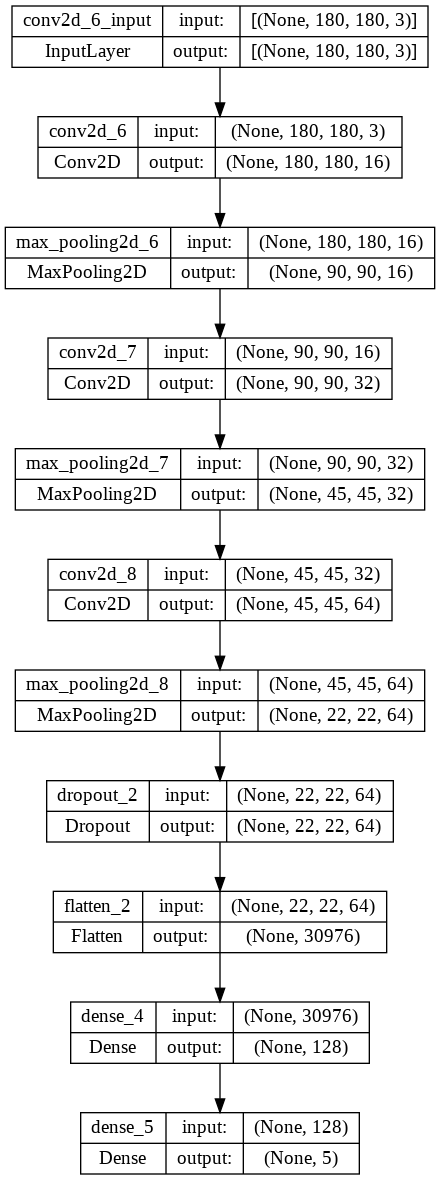

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 22, 22, 64)      

In [ ]:
epochs=20
history = model.fit(transformed_ds_train,validation_data=transformed_ds_val, epochs=epochs)

Epoch 1/20
92/92 [==============================] - 20s 106ms/step - loss: 1.3285 - accuracy: 0.4356 - val_loss: 1.2523 - val_accuracy: 0.5150
Epoch 2/20
92/92 [==============================] - 9s 95ms/step - loss: 1.1255 - accuracy: 0.5429 - val_loss: 1.0879 - val_accuracy: 0.5995
Epoch 3/20
92/92 [==============================] - 10s 99ms/step - loss: 1.0308 - accuracy: 0.5889 - val_loss: 0.9690 - val_accuracy: 0.6485
Epoch 4/20
92/92 [==============================] - 10s 97ms/step - loss: 0.9672 - accuracy: 0.6206 - val_loss: 0.9161 - val_accuracy: 0.6540
Epoch 5/20
92/92 [==============================] - 10s 98ms/step - loss: 0.8832 - accuracy: 0.6563 - val_loss: 0.9671 - val_accuracy: 0.6022
Epoch 6/20
92/92 [==============================] - 10s 101ms/step - loss: 0.8486 - accuracy: 0.6703 - val_loss: 0.8915 - val_accuracy: 0.6240
Epoch 7/20
92/92 [==============================] - 10s 97ms/step - loss: 0.8207 - accuracy: 0.6740 - val_loss: 0.8514 - val_accuracy: 0.6757
Epoch

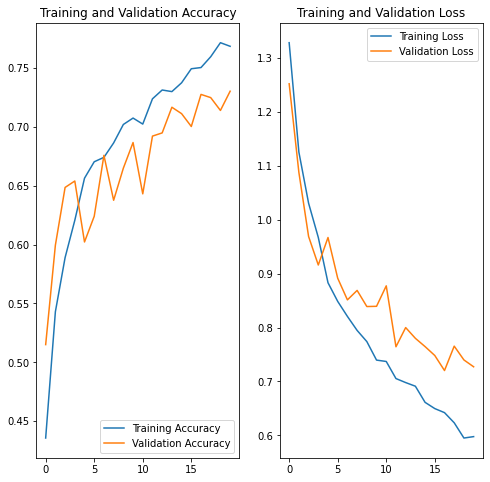

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

121411/121411 [==============================] - 0s 0us/step


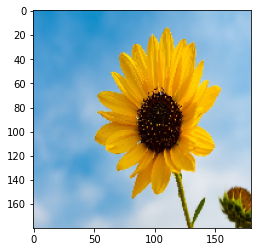

In [ ]:
image_url = "https://static.wixstatic.com/media/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg/v1/fill/w_1000,h_666,al_c,q_90,usm_0.66_1.00_0.01/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg"
image_path = tf.keras.utils.get_file("image_test", image_url)
img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
plt.imshow(img)

In [ ]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = tf.convert_to_tensor(img_array)
img_tensor = tf.expand_dims(img_tensor, 0) 
img_tensor = tf.divide(img_tensor, 255.0)
# scores = model(img_tensor)
# probs = tf.nn.softmax(scores).numpy().squeeze()
probs = model(img_tensor)
class_idx = np.argmax(probs)
print(class_idx)
print(f"this image was classified as {labels[class_idx]} with a probability of {probs[0, class_idx]}")

3
this image was classified as sunflowers with a probability of 0.9969304203987122


In [ ]:
MODEL_DIR = Path("/content/flowers_model/")

In [ ]:
model.save(MODEL_DIR, save_format="tf")

In [ ]:
!saved_model_cli show --dir {MODEL_DIR} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_6_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 180, 180, 3)
        name: serving_default_conv2d_6_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_5'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          co

In [ ]:
import shutil
from pathlib import Path
from google.colab import files
import sys

def folder_to_zip(folder_path):
    folder_path = Path(folder_path)
    if not folder_path.exists():
        return
    shutil.make_archive(folder_path.name, 'zip', folder_path)
    return folder_path.with_suffix(".zip")

def zip_and_download_folder_content(model_folder):
    zip_file = folder_to_zip(model_folder)
    files.download(zip_file)


In [ ]:
zip_and_download_folder_content("flowers_model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>